In [1]:
from headers import *
from scipy.interpolate import interp1d
%matplotlib notebook

Defining a Class for DMPs

In [2]:
class DMP():
	
	def __init__(self,timesteps=100):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = timesteps
		self.tau = self.time_steps

		self.dimensions = 3
# 		self.number_kernels = max(self.time_steps,100)
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
# 		self.rollout_time = max(self.time_steps,200)
		self.rollout_time = self.time_steps    
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))                
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)  
		self.initial_velocity = npy.zeros(self.dimensions)

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase        

# 		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]))**2      
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.55))**2            
		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
        
		for k in range(self.dimensions):
			self.eta[:,k] = vector_phase*(self.demo_pos[-1,k]-self.demo_pos[0,k])

	def learn_DMP(self):	
		self.update_target_force_itau()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal,init_vel):
		self.tau = self.rollout_time        
		self.pos_roll[0] = copy.deepcopy(start)        
		self.vel_roll[0] = copy.deepcopy(init_vel)
		self.goal = goal
		self.start = start
		self.dt = self.tau/self.rollout_time        
		print(self.dt)

	def calc_rollout_force(self,roll_time):
		den = 0        
		time = copy.deepcopy(roll_time)        
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.start)*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
		self.acc_roll[time] = (1./self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_roll[time]) - self.tau*self.vel_roll[time]) + self.force_roll[time])    
        
	def calc_rollout_vel(self,time):
		self.vel_roll[time] = self.vel_roll[time-1] + self.acc_roll[time-1]*self.dt

	def calc_rollout_pos(self,time):
		self.pos_roll[time] = self.pos_roll[time-1] + self.vel_roll[time-1]*self.dt
    
	def rollout(self,start,goal,init_vel):

		self.initialize_rollout(start,goal,init_vel)        
		self.calc_rollout_force(0)
		self.calc_rollout_acceleration(0)  
		for i in range(1,self.rollout_time):        
			self.calc_rollout_force(i)     
			self.calc_rollout_vel(i)                     
			self.calc_rollout_pos(i)                                
			self.calc_rollout_acceleration(i) 

In [6]:
# cd ../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_0/Interp_Segment_All

/home/tanmay/Research/Code/ActionPrimitives/Data/Cornell_Data/Primitive_Library/Subject1/Traj_0/Interp_Segment_All


In [17]:
seg_ind = 1
xpos = npy.load("LH_Segment_{0}/interp_demo_pos.npy".format(seg_ind))[:,:3]
xvel = npy.load("LH_Segment_{0}/interp_demo_vel.npy".format(seg_ind))[:,:3]
xacc = npy.load("LH_Segment_{0}/interp_demo_acc.npy".format(seg_ind))[:,:3]


In [20]:
seg_ind = 1
pos = npy.load("LH_Segment_{0}/demo_pos.npy".format(seg_ind))[:,:3]
vel = npy.load("LH_Segment_{0}/demo_vel.npy".format(seg_ind))[:,:3]
acc = npy.load("LH_Segment_{0}/demo_acc.npy".format(seg_ind))[:,:3]

interp_time_points = 100
tr = npy.linspace(0,len(pos)-1,len(pos))
tr_new = npy.linspace(0,len(pos)-1,interp_time_points+2)

ipos = npy.zeros((interp_time_points+2,3))
ivel = npy.zeros((interp_time_points,3))
iacc = npy.zeros((interp_time_points,3))

dt_mul = float(len(pos))/interp_time_points

for k in range(3):
    pos_f = interp1d(tr,pos[:,k],kind='linear')
    ipos[:,k] = pos_f(tr_new)
    
#     vel_f = interp1d(tr,vel[:,k],kind='linear')
#     ivel[:,k] = dt_mul*vel_f(tr_new)

#     acc_f = interp1d(tr,acc[:,k],kind='linear')
#     iacc[:,k] = dt_mul*acc_f(tr_new)

# ivel = npy.cumsum(iacc*dt_mul,axis=0)+vel[0]
# ipos = npy.cumsum(ivel*dt_mul,axis=0)+pos[0]
    
ivel = npy.diff(ipos,axis=0)[:interp_time_points]
iacc = npy.diff(ipos,axis=0,n=2)[:interp_time_points]
ipos = ipos[:interp_time_points]

In [21]:
dmp = DMP(len(xpos))	
# dmp.load_trajectory(ipos,ivel,iacc)
dmp.load_trajectory(xpos,xvel,xacc)
# dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
dmp.learn_DMP()

<IPython.core.display.Javascript object>


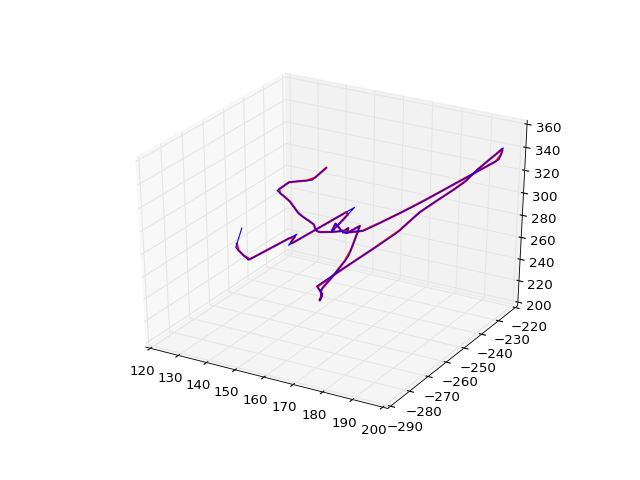

In [23]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(ipos[:,0],ipos[:,1],ipos[:,2],'r',linewidth=2)
ax.plot(pos[:,0],pos[:,1],pos[:,2],'b')
plt.show()

<IPython.core.display.Javascript object>


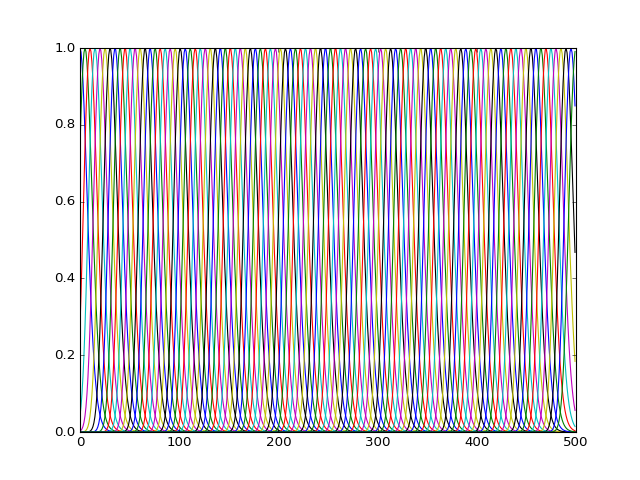

In [11]:
fig,ax = plt.subplots()
b = npy.zeros((dmp.number_kernels,dmp.time_steps))
for i in range(dmp.number_kernels):
    for t in range(dmp.time_steps):
        b[i,t]=dmp.basis(i,t)        
    ax.plot(range(dmp.time_steps),b[i])    

plt.show()
# dmp.tau =100 

<IPython.core.display.Javascript object>


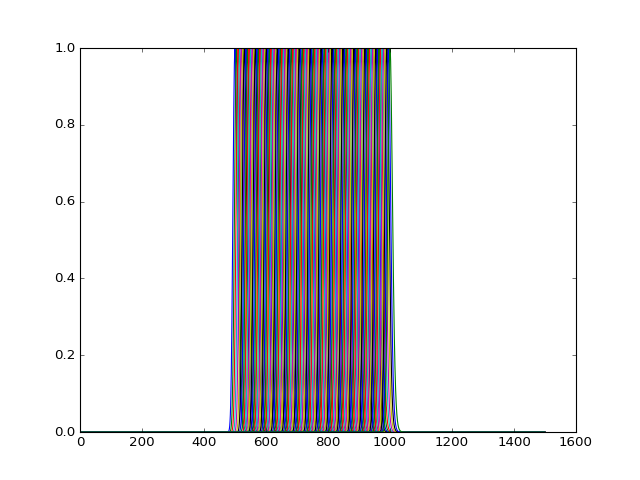

In [12]:
fig,ax = plt.subplots()
b = npy.zeros((dmp.number_kernels,3*dmp.time_steps))
for i in range(dmp.number_kernels):
#     for t in range(2*dmp.time_steps):
    for t in range(-dmp.time_steps,2*dmp.time_steps):
        b[i,t+dmp.time_steps]=dmp.basis(i,t)        
    ax.plot(range(3*dmp.time_steps),b[i])    

plt.show()
# dmp.tau =100 

<IPython.core.display.Javascript object>


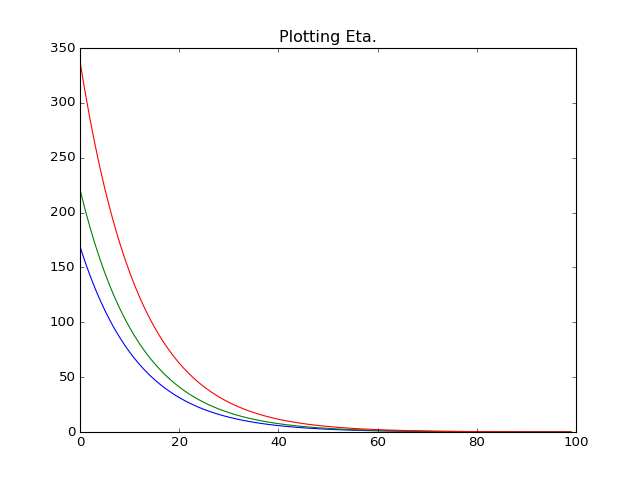

In [10]:
plt.plot(range(dmp.time_steps),dmp.eta)
plt.title("Plotting Eta.")
plt.show()

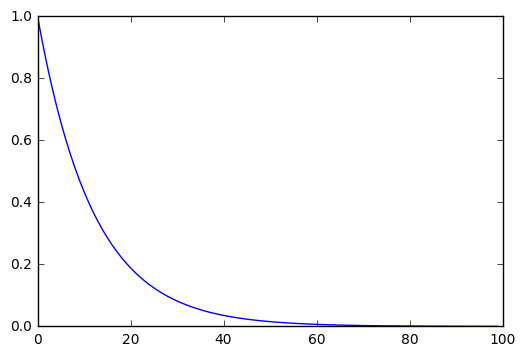

In [87]:
pv = npy.zeros(dmp.time_steps)
for i in range(dmp.time_steps):
    pv[i] = dmp.calc_phase(i)
plt.plot(range(dmp.time_steps),pv)
plt.show()

<IPython.core.display.Javascript object>


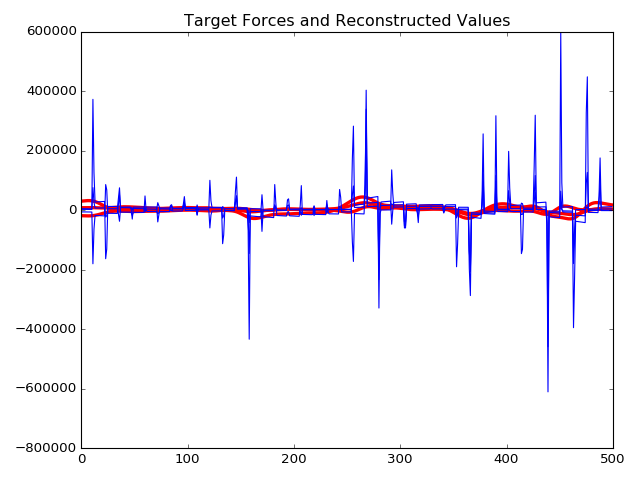

In [24]:
force = npy.zeros((dmp.time_steps,dmp.dimensions))
dmp.goal = copy.deepcopy(dmp.demo_pos[-1])

for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)   
    for k in range(dmp.dimensions):
        force[t,k]*=(dmp.goal[k]-dmp.demo_pos[0,k])*dmp.calc_phase(t)/den

tr = range(0,dmp.time_steps)
fig,ax= plt.subplots()
ax.plot(tr,force,'r',label='Reconstructed Forces',linewidth=3)
ax.plot(tr,dmp.target_forces,'b',label='Target Forces')
ax.set_title("Target Forces and Reconstructed Values")
plt.tight_layout()
plt.show()

In [25]:
normalized_demo = copy.deepcopy(dmp.demo_pos)
normalization_vector = dmp.demo_pos[-1]-dmp.demo_pos[0]
normalized_demo -= normalized_demo[0]
normalized_demo /= normalized_demo[-1]

normalized_initial_velocity = npy.diff(normalized_demo,axis=0)[0]
normalized_initial_velocity

array([ 0.00513533, -0.03310276,  0.00737121])

In [26]:
start = npy.zeros(dmp.dimensions)
goal = npy.ones(dmp.dimensions)
dmp.rollout(start, goal,normalized_initial_velocity)
# dmp.rollout(start,goal,npy.zeros(3))

1


<IPython.core.display.Javascript object>


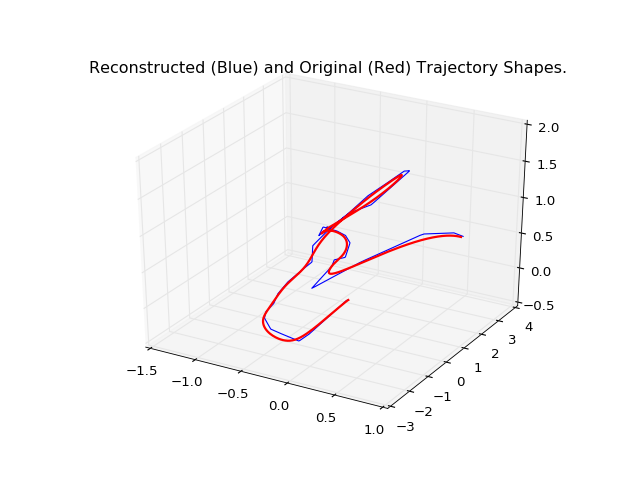

In [27]:
fig = plt.figure()
ax = fig.gca(projection='3d')

np = copy.deepcopy(dmp.demo_pos)
np -= np[0]
np /= np[-1]

nointerp = copy.deepcopy(pos)
nointerp -= nointerp[0]
nointerp /= nointerp[-1]

ax.plot(np[:,0],np[:,1],np[:,2],'b')
# ax.plot(nointerp[:,0],nointerp[:,1],nointerp[:,2],'g',linewidth=2)
ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2],'r',linewidth=2)
# ax.scatter(dmp.pos_roll[ind,0],dmp.pos_roll[ind,1],dmp.pos_roll[ind,2],'r',s=100)
ax.set_title("Reconstructed (Blue) and Original (Red) Trajectory Shapes.")
plt.show()

In [57]:
dmp.pos_roll

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -4.43795911e-04,   1.39875045e-03,  -5.86801481e-04],
       [ -1.03622320e-03,   2.66557398e-03,  -1.15174143e-03],
       ..., 
       [  1.00031954e+00,   9.95935489e-01,   1.00498543e+00],
       [  9.99632506e-01,   9.97795405e-01,   1.00254905e+00],
       [  9.98814618e-01,   9.99586207e-01,   1.00009309e+00]])

In [59]:
dmp.demo_vel

array([[-0.0748503 ,  0.31437126, -0.19461078],
       [-0.0748503 ,  0.31437126, -0.19461078],
       [-0.0748503 ,  0.31437126, -0.19461078],
       ..., 
       [-0.17964072,  0.3742515 , -0.82335329],
       [-0.17964072,  0.3742515 , -0.82335329],
       [-0.17964072,  0.3742515 , -0.82335329]])

In [60]:
dmp.weights

array([[ -1.90420978e+02,  -1.63515028e+02,  -1.59661016e+02],
       [ -2.26717195e+02,  -1.98129232e+02,  -1.52742576e+02],
       [ -2.04553709e+02,  -1.98305711e+02,  -1.76411409e+02],
       [ -2.01548969e+02,  -1.98406812e+02,  -2.01069401e+02],
       [ -2.39152375e+02,  -2.29509227e+02,  -2.16083509e+02],
       [ -2.21201345e+02,  -2.87834964e+02,  -2.40400996e+02],
       [ -2.37824146e+02,  -2.38031836e+02,  -2.48610732e+02],
       [ -2.36465479e+02,  -2.45063341e+02,  -2.69153524e+02],
       [ -2.40618655e+02,  -3.60537317e+02,  -3.04074290e+02],
       [ -3.67181385e+02,  -4.23360619e+02,  -3.17964726e+02],
       [ -3.73289561e+02,  -3.22069627e+02,  -3.53990585e+02],
       [ -3.21417370e+02,  -3.36470145e+02,  -3.69555681e+02],
       [ -3.11585905e+02,  -4.68137486e+02,  -3.77877964e+02],
       [ -4.86576194e+02,  -4.25967185e+02,  -4.58678028e+02],
       [ -5.26453796e+02,  -4.17446453e+02,  -5.45953060e+02],
       [ -6.17456683e+02,  -5.81243989e+02,  -5.7319180

In [61]:
dmp.dt, dmp.tau, dmp.rollout_time

(1, 500, 500)